In [1]:
## OBJECTIVE 

# Understanding user behavior through implicit signals like clicks and views is crucial for building effective recommender systems
# in real-world e-commerce platforms. Being able to predict preferences from limited interaction data helps personalize user experience,
# boosting engagement and conversions. Simultaneously, detecting and removing abnormal traffic is essential to ensure the recommendations
# are based on genuine customer behavior and do not suffer from noise or bias—leading to better decision-making and higher ROI for businesses.

# Can we accurately predict item properties associated with “addtocart” events based on a visitor’s prior “view” behavior,
# and can we detect and filter out abnormal user activity to improve the performance of recommender systems?

In [3]:
# Lets import the necessary libraries 
import pandas as pd
import numpy as np
import time

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [5]:
## LOADING DATA

# The data will be sourced from the publicly available RetailRocket Recommender System Dataset
# https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset which includes:
# events.csv – records user interactions (view, add to cart, transaction)
# item_properties_part1.csv and item_properties_part2.csv – describe time-stamped item properties
# category_tree.csv – describes the hierarchical relationships between product categories

In [7]:
event_data = pd.read_csv('data/events.csv')
category_data = pd.read_csv('data/category_tree.csv')
item_data = pd.concat([pd.read_csv('data/item_properties_part1.csv'),pd.read_csv('data/item_properties_part2.csv')])

print("Here are the number of records in each file")
print("Events shape:", event_data.shape)
print("Category tree shape:", category_data.shape)
print("Item properties shape:", item_data.shape)

Here are the number of records in each file
Events shape: (2756101, 5)
Category tree shape: (1669, 2)
Item properties shape: (20275902, 4)


In [9]:
# EXPLORATORY DATA ANALYSIS (EDA)

In [11]:
event_data['timestamp'] = pd.to_datetime(event_data['timestamp'], unit='ms')
event_data.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [13]:
event_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.1+ MB


In [15]:
event_data.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [17]:
print('Number of unique visitors = {:,}'.format(len(event_data['visitorid'].unique())))
print('Number of unique items = {:,}'.format(len(event_data['itemid'].unique())))
print('Number of unique transactions = {:,}'.format(len(event_data['transactionid'].unique())))

Number of unique visitors = 1,407,580
Number of unique items = 235,061
Number of unique transactions = 17,673


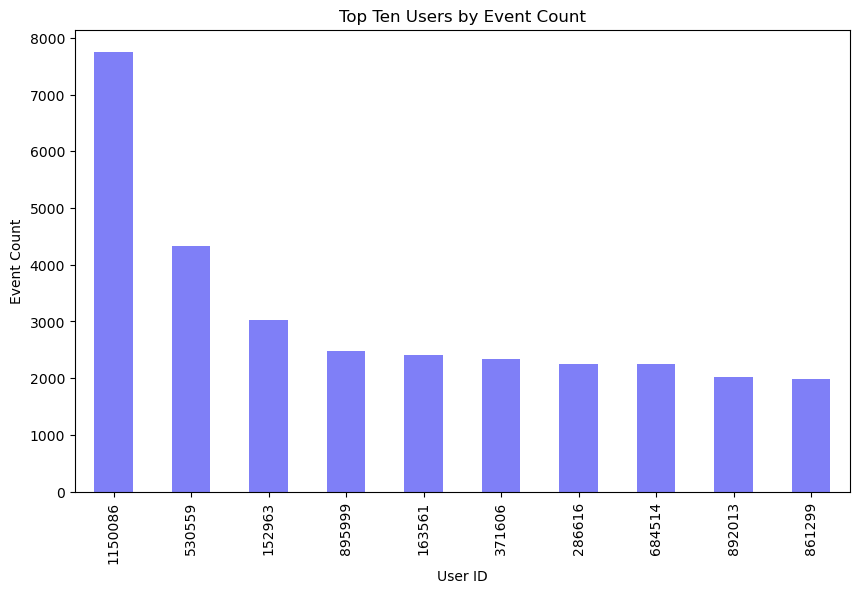

In [19]:
user_count= event_data['visitorid'].value_counts()
top_ten_users= user_count.head(10)

plt.figure(figsize=(10, 6))
top_ten_users.plot(kind='bar',color='#0000F080')
plt.title('Top Ten Users by Event Count')
plt.xlabel('User ID')
plt.ylabel('Event Count')
plt.savefig("images/Top_ten_Users.png")

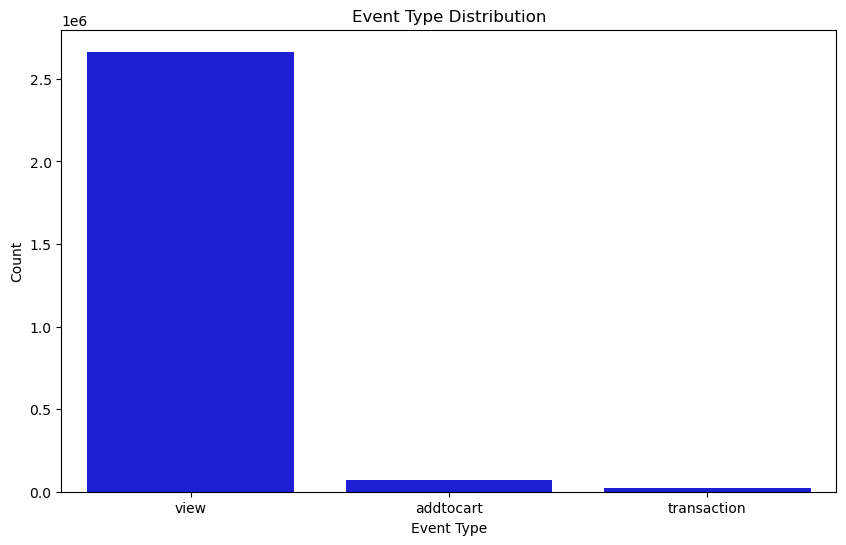

<Figure size 640x480 with 0 Axes>

In [21]:
event_counts = event_data['event'].value_counts()

# Visualize with a countplot
plt.figure(figsize=(10,6))
sns.countplot(x='event', data=event_data, order=event_counts.index, color='#0000F080')
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()
plt.savefig("images/Event_type_count.png")

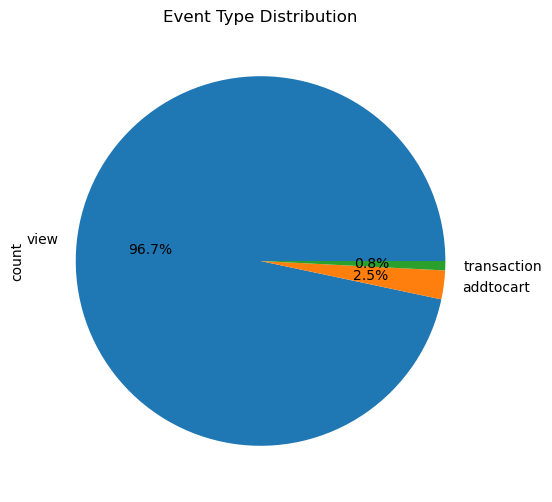

<Figure size 640x480 with 0 Axes>

In [23]:
plt.figure(figsize=(10, 6))
event_percentage = (event_counts / len(event_data)) * 100
event_percentage.plot(kind='pie',autopct='%1.1f%%')
plt.title('Event Type Distribution')
plt.show()
plt.savefig("images/Event_tupe_pie.png")

In [25]:
# Only 0.8% of the views are converted into purchases and 2.5% result in add to cart

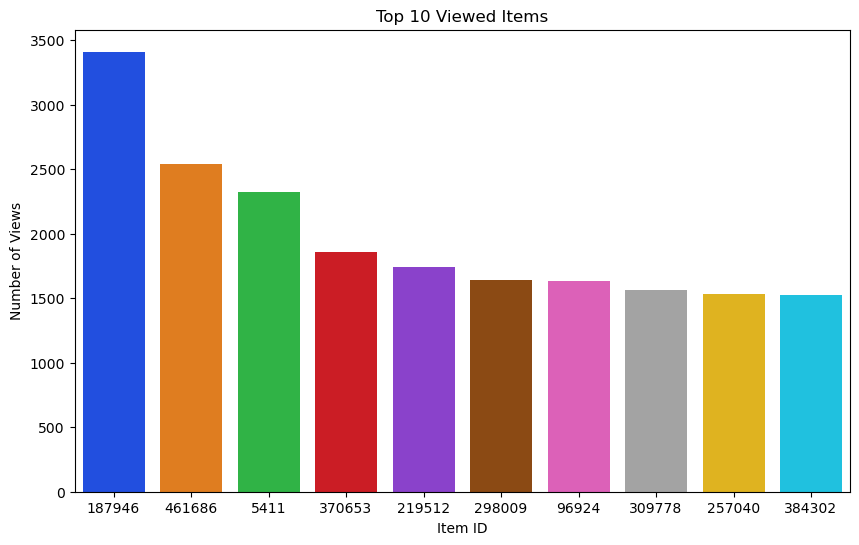

<Figure size 640x480 with 0 Axes>

In [27]:
# plot top 10 views item
top_viewed_items = event_data[event_data['event'] == 'view']['itemid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_viewed_items.index, y=top_viewed_items.values, order=top_viewed_items.index,palette="bright")
plt.title('Top 10 Viewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.show()
plt.savefig("images/Top_ten_Viewed_Items.png")

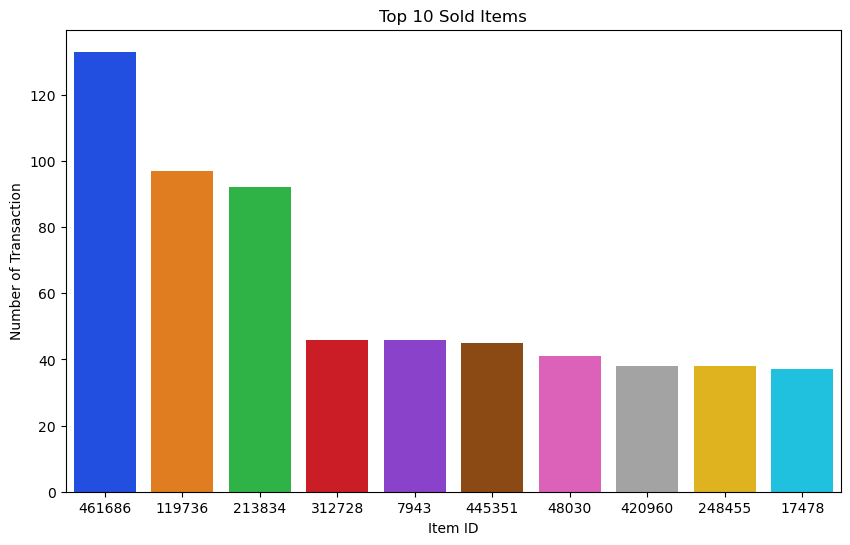

<Figure size 640x480 with 0 Axes>

In [29]:
# plot top 10 transaction item
top_sold_items = event_data[event_data['event'] == 'transaction']['itemid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_sold_items.index, y=top_sold_items.values,order=top_sold_items.index, palette="bright")
plt.title('Top 10 Sold Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Transaction')
plt.show()
plt.savefig("images/Top_ten_sold_items.png")

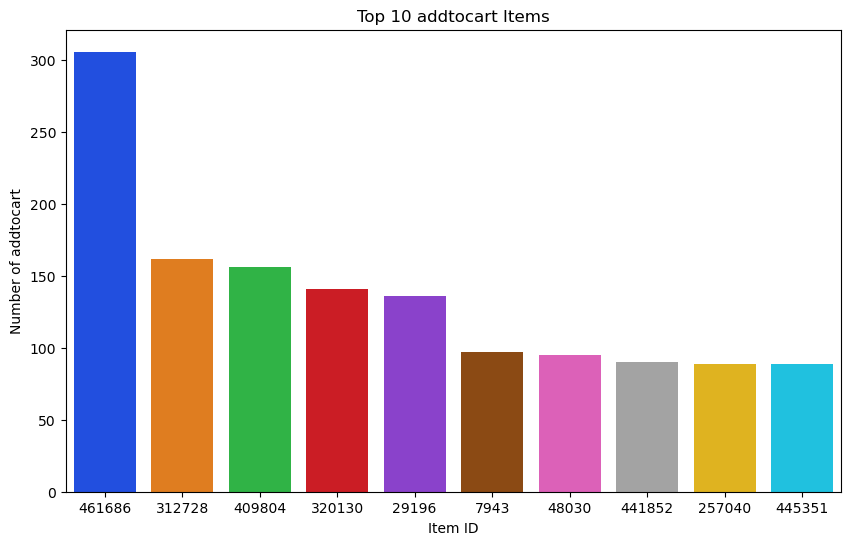

<Figure size 640x480 with 0 Axes>

In [31]:
top_atc_items = event_data[event_data['event'] == 'addtocart']['itemid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_atc_items.index, y=top_atc_items.values, order=top_atc_items.index, palette="bright")
plt.title('Top 10 addtocart Items')
plt.xlabel('Item ID')
plt.ylabel('Number of addtocart')
plt.show()
plt.savefig("images/Top_ten_Items_AddedtoCart.png")

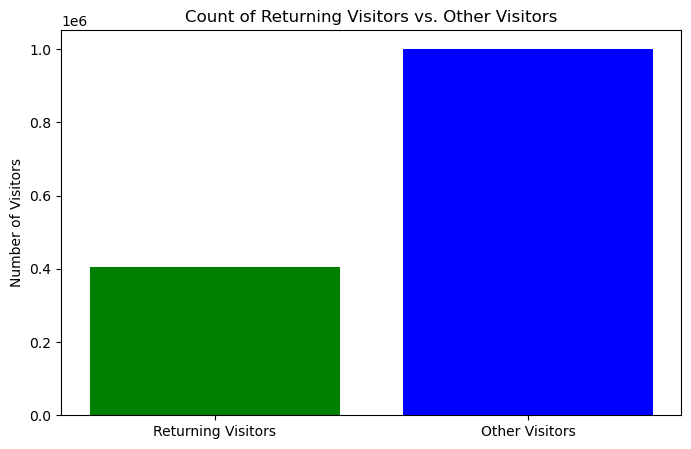

<Figure size 640x480 with 0 Axes>

In [33]:
# Calculate the number of events per visitor
events_per_visitor = event_data.groupby('visitorid')['event'].count().reset_index()
events_per_visitor.columns = ['visitorid', 'num_events']

# Identify returning visitors (those with more than one event)
returning_visitors = events_per_visitor[events_per_visitor['num_events'] > 1]

# Plot the count of returning visitors
plt.figure(figsize=(8, 5))
plt.bar(['Returning Visitors', 'Other Visitors'], [len(returning_visitors), len(events_per_visitor) - len(returning_visitors)], color=['green', 'blue'])
plt.title('Count of Returning Visitors vs. Other Visitors')
plt.ylabel('Number of Visitors')
plt.show()
plt.savefig("images/ReturningUsersvsNew.png")

In [21]:
# Understanding the Data

In [16]:
# Understanding the Features

In [24]:
# Engineering Features

In [28]:
# Train/Test Split